# Sundial: Zero-Shot Blood Glucose Forecasting

**Model**: thuml/sundial-base-128m (128M parameters)  
**Dataset**: Kaggle BrisT1D  
**Task**: Nocturnal blood glucose forecasting (6 hours)

**Requirements:** `pip install transformers`

Sundial is a generative time series foundation model (ICML 2025 Oral) pretrained on 1 trillion time points. It generates multiple probable predictions, allowing estimation of means, quantiles, and confidence intervals.

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from transformers import AutoModelForCausalLM

from src.data.diabetes_datasets.data_loader import get_loader
from src.data.models import ColumnNames
from src.utils.time_series_helper import get_interval_minutes
from src.data.preprocessing.time_processing import iter_daily_context_forecast_splits

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")


def compute_metrics(predictions, targets):
    """Compute RMSE, MAE, MAPE for forecast evaluation."""
    y_pred = np.asarray(predictions).flatten()
    y_true = np.asarray(targets).flatten()
    return {
        "rmse": float(root_mean_squared_error(y_true, y_pred)),
        "mae": float(mean_absolute_error(y_true, y_pred)),
        "mape": float(
            np.mean(np.abs((y_pred - y_true) / np.where(y_true != 0, y_true, 1e-8)))
            * 100
        ),
    }

Device: cpu


In [2]:
# Configuration
INTERVAL_MINS = 5
NOCTURNAL_HOURS = 6
TARGET_COL = ColumnNames.BG.value

nocturnal_steps = int(NOCTURNAL_HOURS * 60 / INTERVAL_MINS)  # 72 steps
print(f"Predicting {nocturnal_steps} steps ({NOCTURNAL_HOURS} hours)")

Predicting 72 steps (6 hours)


In [3]:
# Load data
loader = get_loader(
    data_source_name="kaggle_brisT1D", dataset_type="train", use_cached=True
)
val_data = loader.validation_data

# Load Sundial model
print("Loading Sundial model...")
model = AutoModelForCausalLM.from_pretrained(
    "thuml/sundial-base-128m",
    trust_remote_code=True
)
model.to(device)
model.eval()
print("Model loaded.")

2026-01-13T21:42:04 - ============================================================
2026-01-13T21:42:04 - Beginning data loading process with the following parmeters:
2026-01-13T21:42:04 - 	Dataset: kaggle_brisT1D - train
2026-01-13T21:42:04 - 	Columns: None
2026-01-13T21:42:04 - 	Generic patient start date: 2024-01-01 00:00:00
2026-01-13T21:42:04 - 	Number of validation days: 20
2026-01-13T21:42:04 - 	In parallel with up to 3 workers.

2026-01-13T21:42:05 - Loaded full processed data from cache for 9 patients
2026-01-13T21:42:05 - Loaded existing train/validation split from cache for 9 patients
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading Sundial model...
Model loaded.


/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
def sundial_forecast(
    context: np.ndarray,
    timestamps: pd.DatetimeIndex,  # unused by Sundial but kept for API consistency
    prediction_length: int,
    num_samples: int = 100,
):
    """
    Run Sundial forecast on univariate context.

    Returns: (median, q05, q95) prediction arrays for 90% PI
    """
    # Prepare input tensor
    seqs = torch.tensor(context, dtype=torch.float32).unsqueeze(0).to(device)

    # Generate samples
    with torch.no_grad():
        samples = model.generate(
            seqs,
            max_new_tokens=prediction_length,
            num_samples=num_samples
        )  # shape: (1, num_samples, prediction_length)

    samples = samples.cpu().numpy()[0]  # (num_samples, prediction_length)

    # Compute quantiles for 90% PI
    median = np.median(samples, axis=0)
    q05 = np.percentile(samples, 5, axis=0)
    q95 = np.percentile(samples, 95, axis=0)

    return median, q05, q95

## Evaluation

Evaluate using day-split validation:
- **Context**: Daytime data (6am-midnight)
- **Target**: Nocturnal period (midnight-6am next day)

In [5]:
# Store per-day results for visualization
day_results = []

for patient_id, patient_df in val_data.items():
    if get_interval_minutes(patient_df) != INTERVAL_MINS:
        continue

    for daytime, nocturnal in iter_daily_context_forecast_splits(patient_df):
        context = daytime[TARGET_COL].values
        target = nocturnal[TARGET_COL].values[:nocturnal_steps]

        if np.isnan(context).any() or np.isnan(target).any():
            continue
        if len(context) < 10 or len(target) < nocturnal_steps:
            continue

        pred, q05, q95 = sundial_forecast(context, daytime.index, nocturnal_steps)

        day_results.append(
            {
                "patient": patient_id,
                "context": context,
                "timestamps": daytime.index,
                "target": target,
                "pred": pred.flatten(),
                "q05": q05.flatten(),
                "q95": q95.flatten(),
                "daytime_df": daytime,  # Keep for CoRA covariates
            }
        )

# Aggregate metrics by patient
patient_metrics = []
for pid in set(r["patient"] for r in day_results):
    patient_days = [r for r in day_results if r["patient"] == pid]
    preds = np.concatenate([r["pred"] for r in patient_days])
    targets = np.concatenate([r["target"] for r in patient_days])
    metrics = compute_metrics(preds, targets)
    patient_metrics.append(
        {
            "patient": pid,
            "rmse": metrics["rmse"],
            "mae": metrics["mae"],
            "days": len(patient_days),
        }
    )
    print(
        f"{pid}: RMSE={metrics['rmse']:.3f}, MAE={metrics['mae']:.3f} ({len(patient_days)} days)"
    )

# Overall metrics
all_preds = np.concatenate([r["pred"] for r in day_results])
all_targets = np.concatenate([r["target"] for r in day_results])
overall = compute_metrics(all_preds, all_targets)
print(
    f"\nOverall: RMSE={overall['rmse']:.3f}, MAE={overall['mae']:.3f}, MAPE={overall['mape']:.1f}%"
)

p02: RMSE=3.208, MAE=2.474 (16 days)
p11: RMSE=2.193, MAE=1.797 (17 days)
p12: RMSE=2.852, MAE=2.098 (16 days)
p03: RMSE=3.292, MAE=2.498 (18 days)
p04: RMSE=1.774, MAE=1.396 (16 days)
p10: RMSE=1.409, MAE=1.049 (15 days)

Overall: RMSE=2.579, MAE=1.906, MAPE=23.9%


In [6]:
pd.DataFrame(patient_metrics)

,patient,rmse,mae,days
0,p02,3.207833,2.474469,16
1,p11,2.192668,1.796822,17
2,p12,2.851683,2.097747,16
3,p03,3.292160,2.498400,18
4,p04,1.773706,1.396406,16
5,p10,1.408610,1.048881,15


## Visualization

Example forecast with 90% prediction interval (q05-q95).

Patient p10: 15 valid days


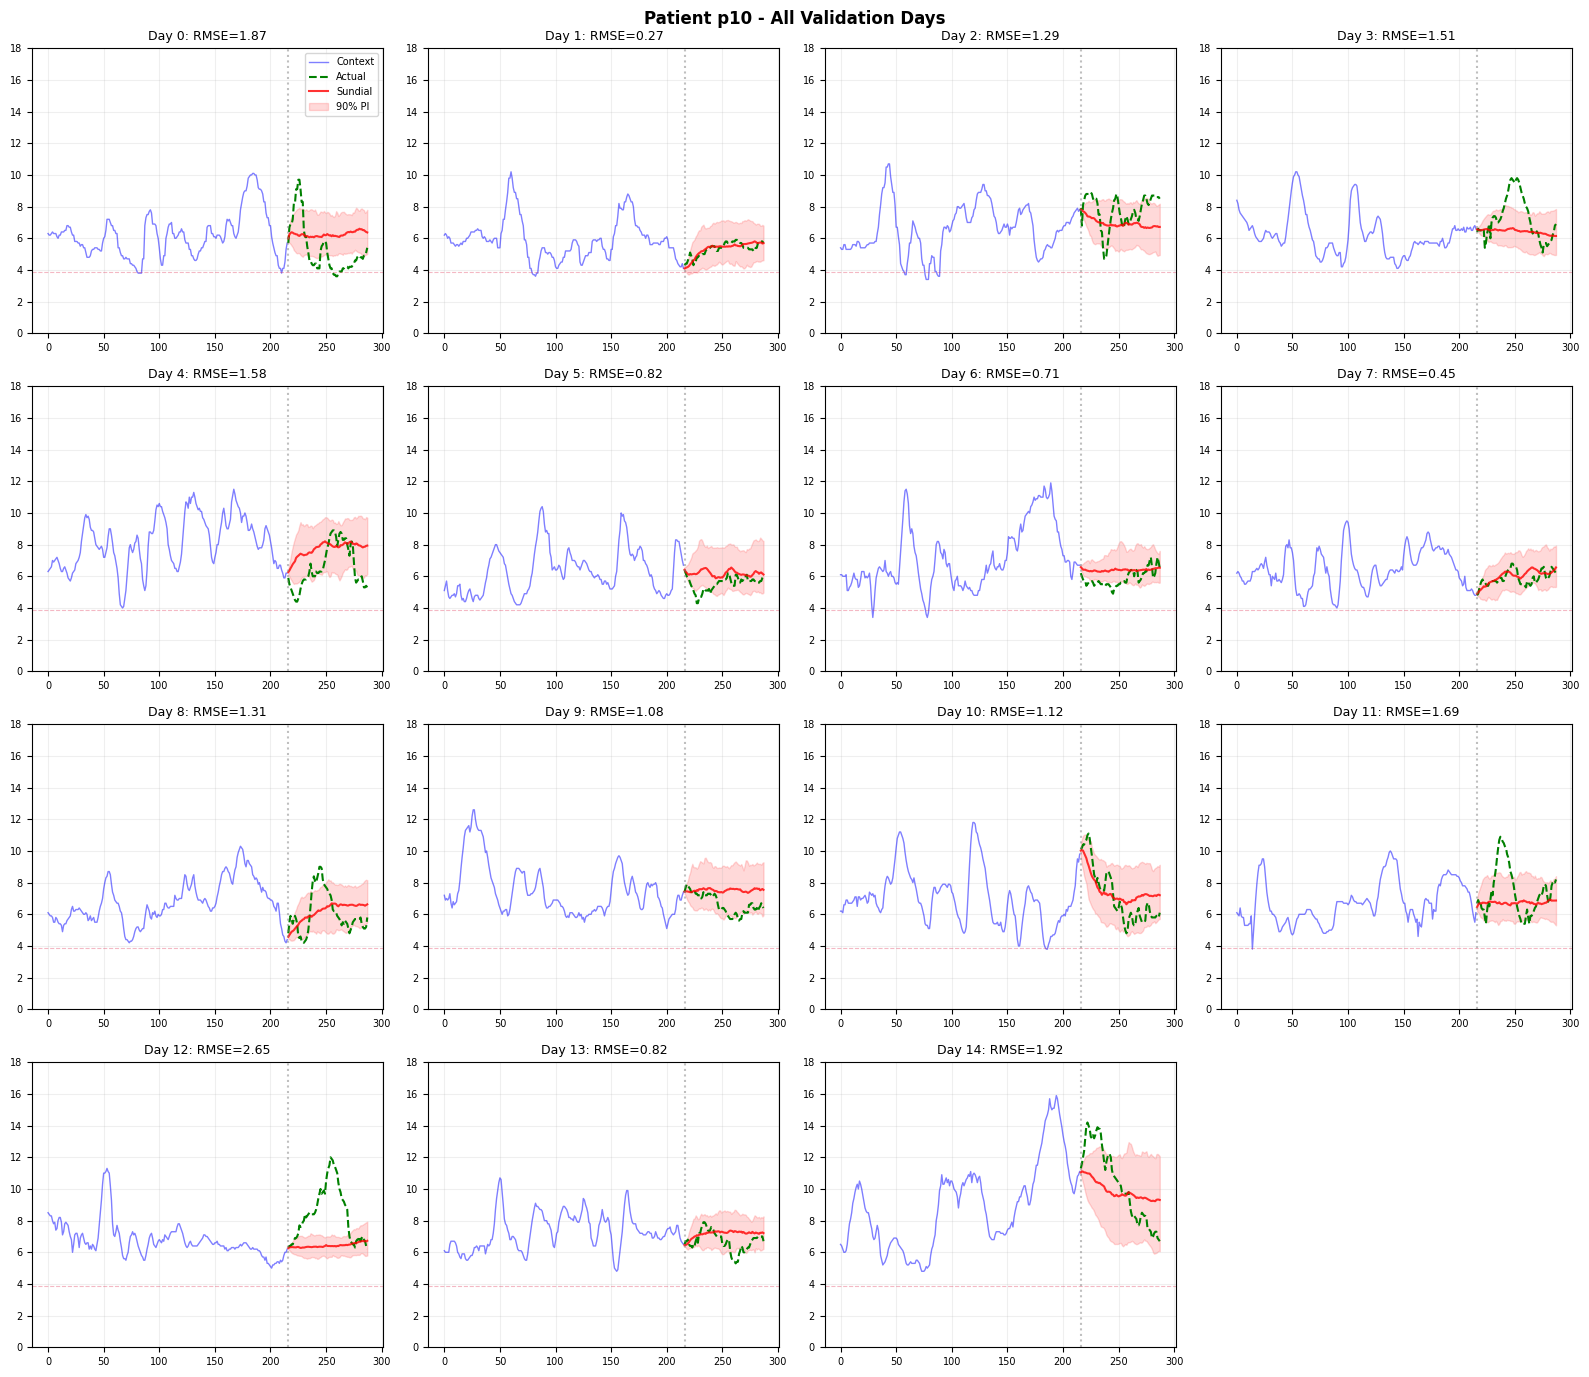

In [7]:
# Plot all days for a patient
PATIENT = "p10"
NCOLS = 4

patient_days = [r for r in day_results if r["patient"] == PATIENT]
num_days = len(patient_days)
print(f"Patient {PATIENT}: {num_days} valid days")

if num_days > 0:
    nrows = int(np.ceil(num_days / NCOLS))
    fig, axes = plt.subplots(nrows, NCOLS, figsize=(4 * NCOLS, 3.5 * nrows))
    axes = np.array(axes).flatten() if num_days > 1 else [axes]

    for i, day in enumerate(patient_days):
        ax = axes[i]
        context, target = day["context"], day["target"]
        pred, q05, q95 = day["pred"], day["q05"], day["q95"]

        t_ctx = np.arange(len(context))
        t_pred = np.arange(len(context), len(context) + len(target))

        ax.plot(t_ctx, context, "b-", alpha=0.5, lw=1, label="Context")
        ax.plot(t_pred, target, "g--", lw=1.5, label="Actual")
        ax.plot(t_pred, pred, "r-", lw=1.5, alpha=0.8, label="Sundial")
        ax.fill_between(t_pred, q05, q95, alpha=0.15, color="red", label="90% PI")

        ax.axvline(len(context), color="gray", ls=":", alpha=0.5)
        ax.axhline(3.9, color="crimson", ls="--", alpha=0.3, lw=0.8)

        rmse = compute_metrics(pred, target)["rmse"]
        ax.set_title(f"Day {i}: RMSE={rmse:.2f}", fontsize=9)
        ax.set_ylim(0, 18)
        ax.tick_params(labelsize=7)
        ax.grid(alpha=0.2)

    for j in range(num_days, len(axes)):
        axes[j].set_visible(False)

    axes[0].legend(fontsize=7, loc="upper right")
    fig.suptitle(f"Patient {PATIENT} - All Validation Days", fontsize=12, fontweight="bold")
    plt.tight_layout()
    plt.show()

---

## CoRA: Covariate-Aware Adaptation

Add covariates (IOB, COB, steps, calories) via a lightweight adapter that modulates Sundial's predictions.

**CoRA** uses:
1. **Granger Causality Embedding (GCE)**: Learns which covariates matter most
2. **Adaptive LayerNorm (adaLN)**: Modulates predictions with learned (γ, β, α) parameters

Only ~500 trainable parameters while Sundial backbone stays frozen.

In [8]:
import torch.nn as nn
import torch.nn.functional as F
from src.data.preprocessing.imputation import impute_missing_values

EXOG_FEATURES = [
    ColumnNames.IOB.value,
    ColumnNames.COB.value,
    ColumnNames.STEPS.value,
    ColumnNames.CALS.value,
]


class SundialCoRAAdapter(nn.Module):
    """Minimal CoRA adapter for Sundial with covariate support."""

    def __init__(self, sundial_model, hidden_dim=64):
        super().__init__()
        self.sundial = sundial_model
        # Freeze backbone
        for p in self.sundial.parameters():
            p.requires_grad = False

        # Covariate projections (IOB, COB, steps, cals)
        self.cov_projs = nn.ModuleList([nn.Linear(1, hidden_dim) for _ in range(4)])

        # GCE: learnable importance weights per covariate
        self.gce_weights = nn.Parameter(torch.zeros(4))

        # adaLN MLP: produces (gamma, beta, alpha)
        self.adaln_mlp = nn.Sequential(
            nn.Linear(hidden_dim, 64), nn.SiLU(), nn.Linear(64, 3)
        )
        # Zero-init output layer for stable start
        nn.init.zeros_(self.adaln_mlp[-1].weight)
        nn.init.zeros_(self.adaln_mlp[-1].bias)

    def forward(self, bg_context, covariates, pred_len, num_samples=100):
        """
        Args:
            bg_context: (seq_len,) numpy array of BG values
            covariates: dict with 'iob', 'cob', 'steps', 'cals' numpy arrays
            pred_len: number of steps to forecast
            num_samples: number of probabilistic samples
        Returns:
            modulated samples (num_samples, pred_len)
        """
        # 1. Project covariates and aggregate temporally (mean pool)
        cov_list = [
            covariates["iob"],
            covariates["cob"],
            covariates["steps"],
            covariates["cals"],
        ]
        cov_embeds = []
        for i, cov in enumerate(cov_list):
            x = torch.tensor(cov, dtype=torch.float32, device=device).unsqueeze(-1)
            embed = self.cov_projs[i](x).mean(dim=0)  # temporal mean
            cov_embeds.append(embed)
        cov_embeds = torch.stack(cov_embeds)  # (4, hidden_dim)

        # 2. GCE: weighted combination
        weights = F.softmax(self.gce_weights, dim=0)  # (4,)
        H = (weights.unsqueeze(-1) * cov_embeds).sum(dim=0)  # (hidden_dim,)

        # 3. Generate adaLN parameters
        params = self.adaln_mlp(H)  # (3,)
        gamma, beta, alpha = params[0], params[1], params[2]

        # 4. Get base Sundial prediction
        seqs = torch.tensor(bg_context, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            samples = self.sundial.generate(
                seqs, max_new_tokens=pred_len, num_samples=num_samples
            )  # (1, num_samples, pred_len)

        # 5. Apply adaLN modulation: x̂ = (1 + α) × pred × (1 + β) + γ
        samples = samples.squeeze(0)  # (num_samples, pred_len)
        modulated = (1 + alpha) * samples * (1 + beta) + gamma

        return modulated


def get_covariates(daytime_df):
    """Extract and impute covariates from daytime DataFrame."""
    df = daytime_df[EXOG_FEATURES].copy()
    df = impute_missing_values(df, EXOG_FEATURES).ffill().bfill().fillna(0)
    return {
        "iob": df[ColumnNames.IOB.value].values,
        "cob": df[ColumnNames.COB.value].values,
        "steps": df[ColumnNames.STEPS.value].values,
        "cals": df[ColumnNames.CALS.value].values,
    }


print(f"CoRA adapter defined. Covariates: {EXOG_FEATURES}")

CoRA adapter defined. Covariates: ['iob', 'cob', 'steps', 'cals']


In [13]:
# Train CoRA adapter
adapter = SundialCoRAAdapter(model, hidden_dim=64).to(device)
optimizer = torch.optim.Adam(adapter.parameters(), lr=1e-3)

# Filter days with valid covariates
train_days = [
    d for d in day_results 
    if all(f in d["daytime_df"].columns for f in EXOG_FEATURES)
]
print(f"Training on {len(train_days)} days with covariates")

# Count trainable parameters
n_params = sum(p.numel() for p in adapter.parameters() if p.requires_grad)
print(f"Trainable parameters: {n_params}")

NUM_EPOCHS = 50
NUM_SAMPLES = 20  # Fewer samples during training for speed

for epoch in range(NUM_EPOCHS):
    total_loss = 0
    adapter.train()

    for day in train_days:
        covs = get_covariates(day["daytime_df"])
        
        # Forward pass
        pred_samples = adapter(day["context"], covs, nocturnal_steps, num_samples=NUM_SAMPLES)
        target = torch.tensor(day["target"], dtype=torch.float32, device=device)
        
        # MSE loss on mean prediction
        pred_mean = pred_samples.mean(dim=0)
        loss = F.mse_loss(pred_mean, target)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    avg_loss = total_loss / len(train_days)
    
    # Show GCE weights periodically
    if (epoch + 1) % 5 == 0 or epoch == 0:
        weights = F.softmax(adapter.gce_weights, dim=0).detach().cpu().numpy()
        weight_str = ", ".join([f"{EXOG_FEATURES[i].split('_')[0]}={w:.2f}" for i, w in enumerate(weights)])
        print(f"Epoch {epoch+1:2d}: Loss={avg_loss:.4f} | GCE: [{weight_str}]")
    else:
        print(f"Epoch {epoch+1:2d}: Loss={avg_loss:.4f}")

print("\nTraining complete!")

Training on 98 days with covariates
Trainable parameters: 4871
Epoch  1: Loss=7.3133 | GCE: [iob=0.25, cob=0.25, steps=0.25, cals=0.25]
Epoch  2: Loss=6.5592
Epoch  3: Loss=6.4836
Epoch  4: Loss=6.6773
Epoch  5: Loss=6.5085 | GCE: [iob=0.26, cob=0.25, steps=0.24, cals=0.25]
Epoch  6: Loss=6.3702
Epoch  7: Loss=6.6832
Epoch  8: Loss=6.4949
Epoch  9: Loss=6.6812
Epoch 10: Loss=6.5425 | GCE: [iob=0.25, cob=0.23, steps=0.25, cals=0.26]
Epoch 11: Loss=6.6739
Epoch 12: Loss=6.4184
Epoch 13: Loss=6.3077
Epoch 14: Loss=6.1841
Epoch 15: Loss=6.2332 | GCE: [iob=0.26, cob=0.23, steps=0.24, cals=0.28]
Epoch 16: Loss=6.1380
Epoch 17: Loss=6.0547
Epoch 18: Loss=6.3397
Epoch 19: Loss=6.4214
Epoch 20: Loss=6.2270 | GCE: [iob=0.25, cob=0.22, steps=0.24, cals=0.28]
Epoch 21: Loss=5.8075
Epoch 22: Loss=6.2202
Epoch 23: Loss=6.1797
Epoch 24: Loss=6.2731
Epoch 25: Loss=6.4085 | GCE: [iob=0.26, cob=0.21, steps=0.23, cals=0.29]
Epoch 26: Loss=6.3337
Epoch 27: Loss=6.1110
Epoch 28: Loss=6.3109
Epoch 29: Loss=

In [14]:
# Evaluate CoRA adapter
adapter.eval()

cora_results = []
for day in train_days:
    covs = get_covariates(day["daytime_df"])
    
    with torch.no_grad():
        samples = adapter(day["context"], covs, nocturnal_steps, num_samples=100)
    
    samples_np = samples.cpu().numpy()
    pred = np.median(samples_np, axis=0)
    q05 = np.percentile(samples_np, 5, axis=0)
    q95 = np.percentile(samples_np, 95, axis=0)
    
    cora_results.append({
        "patient": day["patient"],
        "target": day["target"],
        "pred_uni": day["pred"],
        "q05_uni": day["q05"],
        "q95_uni": day["q95"],
        "pred_cora": pred,
        "q05_cora": q05,
        "q95_cora": q95,
    })

# Compare metrics
uni_preds = np.concatenate([r["pred_uni"] for r in cora_results])
cora_preds = np.concatenate([r["pred_cora"] for r in cora_results])
targets = np.concatenate([r["target"] for r in cora_results])

uni_metrics = compute_metrics(uni_preds, targets)
cora_metrics = compute_metrics(cora_preds, targets)

print("=" * 50)
print("Comparison: Univariate vs CoRA-adapted Sundial")
print("=" * 50)
print(f"{'Metric':<10} {'Univariate':<15} {'CoRA':<15} {'Change':<10}")
print("-" * 50)
for metric in ["rmse", "mae"]:
    uni_val = uni_metrics[metric]
    cora_val = cora_metrics[metric]
    change = (cora_val - uni_val) / uni_val * 100
    print(f"{metric.upper():<10} {uni_val:<15.3f} {cora_val:<15.3f} {change:+.1f}%")
print("-" * 50)

Comparison: Univariate vs CoRA-adapted Sundial
Metric     Univariate      CoRA            Change    
--------------------------------------------------
RMSE       2.579           2.365           -8.3%
MAE        1.906           1.765           -7.4%
--------------------------------------------------


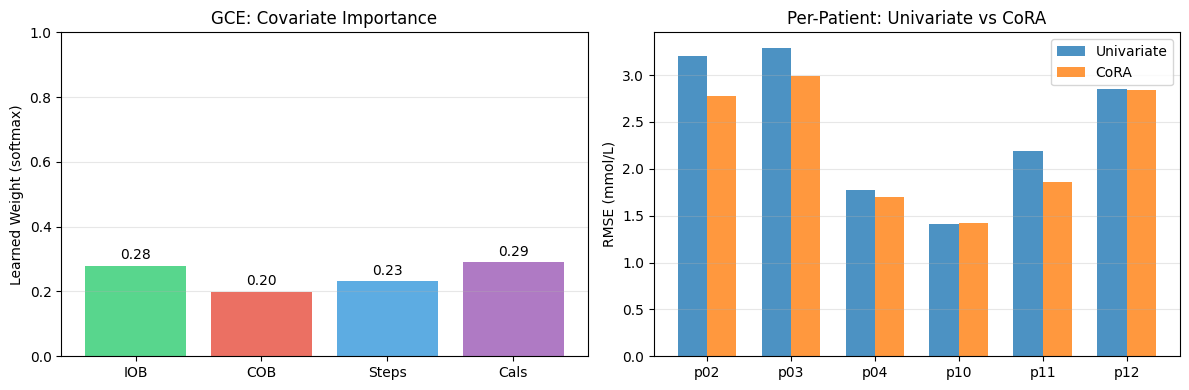

In [15]:
# Visualize learned GCE weights and compare predictions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# GCE weights
ax = axes[0]
weights = F.softmax(adapter.gce_weights, dim=0).detach().cpu().numpy()
labels = ["IOB", "COB", "Steps", "Cals"]
colors = ["#2ecc71", "#e74c3c", "#3498db", "#9b59b6"]
bars = ax.bar(labels, weights, color=colors, alpha=0.8)
ax.set_ylabel("Learned Weight (softmax)")
ax.set_title("GCE: Covariate Importance")
ax.set_ylim(0, 1)
for bar, w in zip(bars, weights):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f"{w:.2f}", ha="center", fontsize=10)
ax.grid(axis="y", alpha=0.3)

# Per-patient comparison
ax = axes[1]
patient_comparison = []
for pid in set(r["patient"] for r in cora_results):
    p_results = [r for r in cora_results if r["patient"] == pid]
    uni = np.concatenate([r["pred_uni"] for r in p_results])
    cora = np.concatenate([r["pred_cora"] for r in p_results])
    tgt = np.concatenate([r["target"] for r in p_results])
    patient_comparison.append({
        "patient": pid,
        "uni_rmse": compute_metrics(uni, tgt)["rmse"],
        "cora_rmse": compute_metrics(cora, tgt)["rmse"],
    })

df_cmp = pd.DataFrame(patient_comparison).sort_values("patient")
x = np.arange(len(df_cmp))
width = 0.35
ax.bar(x - width/2, df_cmp["uni_rmse"], width, label="Univariate", alpha=0.8)
ax.bar(x + width/2, df_cmp["cora_rmse"], width, label="CoRA", alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels(df_cmp["patient"])
ax.set_ylabel("RMSE (mmol/L)")
ax.set_title("Per-Patient: Univariate vs CoRA")
ax.legend()
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

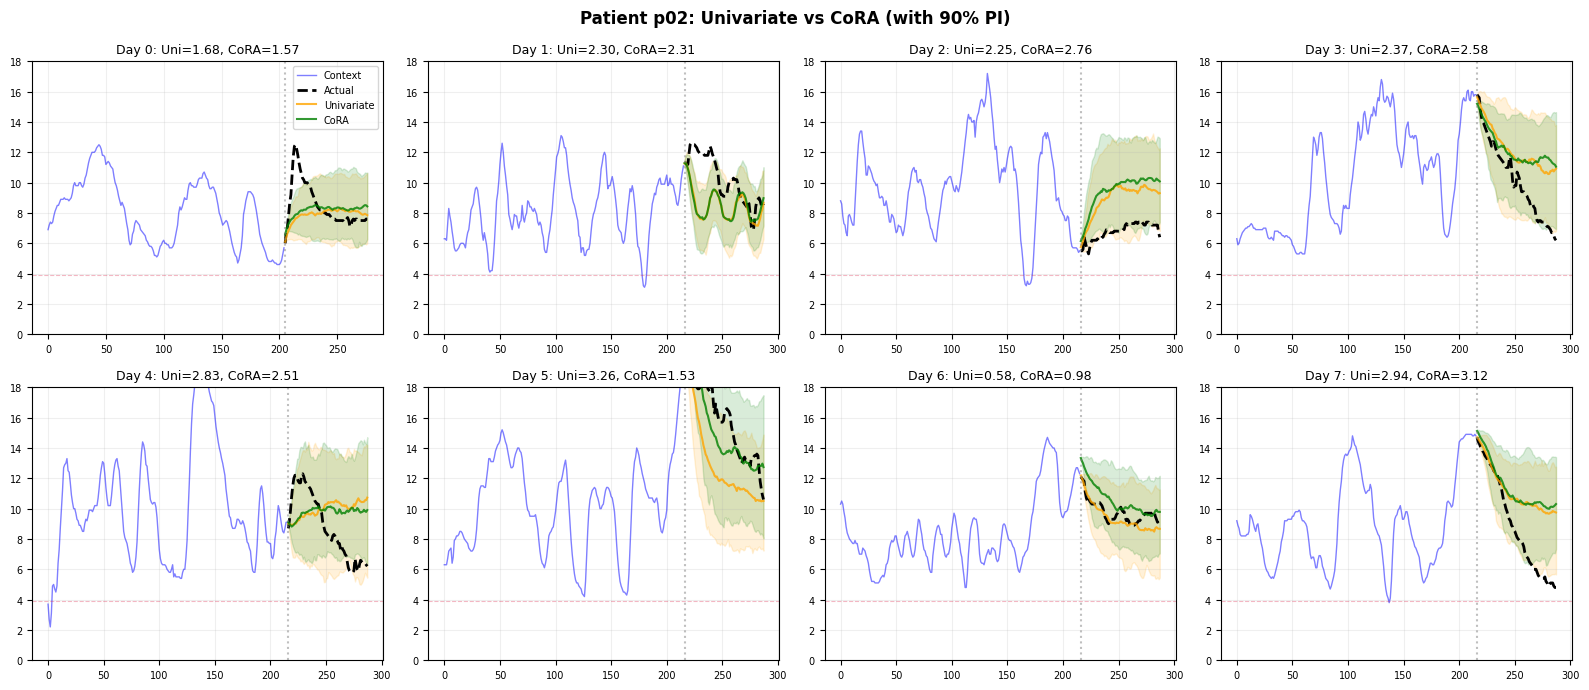

In [17]:
# Plot example days comparing Univariate vs CoRA with 90% PI
PATIENT = "p02"
NCOLS = 4

patient_cora = [r for r in cora_results if r["patient"] == PATIENT]
patient_orig = [d for d in train_days if d["patient"] == PATIENT]
num_days = min(len(patient_cora), 8)

if num_days > 0:
    nrows = int(np.ceil(num_days / NCOLS))
    fig, axes = plt.subplots(nrows, NCOLS, figsize=(4 * NCOLS, 3.5 * nrows))
    axes = np.array(axes).flatten() if num_days > 1 else [axes]

    for i in range(num_days):
        ax = axes[i]
        cora_day = patient_cora[i]
        orig_day = patient_orig[i]
        
        context = orig_day["context"]
        target = cora_day["target"]
        pred_uni = cora_day["pred_uni"]
        pred_cora = cora_day["pred_cora"]

        t_ctx = np.arange(len(context))
        t_pred = np.arange(len(context), len(context) + len(target))

        ax.plot(t_ctx, context, "b-", alpha=0.5, lw=1, label="Context")
        ax.plot(t_pred, target, "k--", lw=2, label="Actual")
        
        # Univariate with 90% PI
        ax.plot(t_pred, pred_uni, "orange", lw=1.5, alpha=0.8, label="Univariate")
        ax.fill_between(t_pred, cora_day["q05_uni"], cora_day["q95_uni"],
                        alpha=0.15, color="orange")
        
        # CoRA with 90% PI
        ax.plot(t_pred, pred_cora, "green", lw=1.5, alpha=0.8, label="CoRA")
        ax.fill_between(t_pred, cora_day["q05_cora"], cora_day["q95_cora"],
                        alpha=0.15, color="green")

        ax.axvline(len(context), color="gray", ls=":", alpha=0.5)
        ax.axhline(3.9, color="crimson", ls="--", alpha=0.3, lw=0.8)

        rmse_uni = compute_metrics(pred_uni, target)["rmse"]
        rmse_cora = compute_metrics(pred_cora, target)["rmse"]
        ax.set_title(f"Day {i}: Uni={rmse_uni:.2f}, CoRA={rmse_cora:.2f}", fontsize=9)
        ax.set_ylim(0, 18)
        ax.tick_params(labelsize=7)
        ax.grid(alpha=0.2)

    for j in range(num_days, len(axes)):
        axes[j].set_visible(False)

    axes[0].legend(fontsize=7, loc="upper right")
    fig.suptitle(f"Patient {PATIENT}: Univariate vs CoRA (with 90% PI)", fontsize=12, fontweight="bold")
    plt.tight_layout()
    plt.show()